In [129]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from torch import nn
import torch
import torch.nn.functional as F
from pytorch_forecasting import TimeSeriesDataSet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, RichProgressBar
from tqdm.autonotebook import tqdm
from lightning.pytorch.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import seaborn as sns

from torchinfo import summary
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [130]:
sp500 = yf.download("^GSPC", period="max", start="2001-1-1")
sp500.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


In [131]:
from typing import Any
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet
import os


class UnivariateSeriesDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data: pd.DataFrame,
        n_lags: int,
        horizon: int,
        test_size: float = 0.2,
        batch_size: int = 16,
        feature_name: str = "Close",
    ) -> None:
        super().__init__()
        self.data = data
        self.n_lags = n_lags
        self.horizon = horizon
        self.test_size = test_size
        self.batch_size = batch_size
        self.feature_name = feature_name
        self.training: TimeSeriesDataSet
        self.validation: TimeSeriesDataSet
        self.test: TimeSeriesDataSet
        self.predict: TimeSeriesDataSet
        self.target_scaler = StandardScaler()
        self.setup()

    def preprocess_data(self):
        self.data["target"] = self.data[self.feature_name]
        self.data["time_index"] = np.arange(len(self.data))
        self.data["group_id"] = 0

    def split_data(self):
        time_indices = self.data["time_index"].values
        train_indices, test_indices = train_test_split(
            time_indices, test_size=self.test_size, shuffle=False
        )
        train_indices, val_indices = train_test_split(
            train_indices, test_size=0.1, shuffle=False
        )
        return train_indices, val_indices, test_indices

    def scale_target(self, df, indices):
        scaled_values = self.target_scaler.transform(df.loc[indices, ["target"]])
        df.loc[indices, "target"] = scaled_values

    def setup(self, stage=None) -> None:
        self.preprocess_data()
        train_indices, val_indices, test_indices = self.split_data()

        train_df = self.data.loc[self.data["time_index"].isin(train_indices)]
        val_df = self.data.loc[self.data["time_index"].isin(val_indices)]
        test_df = self.data.loc[self.data["time_index"].isin(test_indices)]

        self.target_scaler.fit(train_df[["target"]])
        self.scale_target(train_df, train_df.index)
        self.scale_target(val_df, val_df.index)
        self.scale_target(test_df, test_df.index)

        # Setup datasets
        self.training = TimeSeriesDataSet(
            train_df,
            time_idx="time_index",
            target="target",
            group_ids=["group_id"],
            max_encoder_length=self.n_lags,
            max_prediction_length=self.horizon,
            time_varying_unknown_reals=[self.feature_name],
            scalers={name: StandardScaler() for name in [self.feature_name]},
        )
        self.validation = TimeSeriesDataSet.from_dataset(
            self.training, val_df, stop_randomization=True
        )
        self.test = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )
        self.predict = TimeSeriesDataSet.from_dataset(
            self.training, test_df, stop_randomization=True
        )

    def train_dataloader(self) -> Any:
        return self.training.to_dataloader(
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            shuffle=False,
            persistent_workers=True,
        )

    def val_dataloader(self) -> Any:
        return self.validation.to_dataloader(
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            shuffle=False,
            persistent_workers=True,
        )

    def test_dataloader(self) -> Any:
        return self.test.to_dataloader(
            batch_size=self.batch_size,
            num_workers=os.cpu_count(),
            shuffle=False,
            persistent_workers=True,
        )

    def predict_dataloader(self) -> Any:
        return self.predict.to_dataloader(
            batch_size=1,
            num_workers=os.cpu_count(),
            shuffle=False,
            persistent_workers=True,
        )

In [132]:
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("lightning_logs")
N_LAGS = 7
HORIZON = 1

In [133]:
from typing import Any
import torch
from torch import nn
from torch.nn import functional as F


class UnivariateLSTM(pl.LightningModule):
    def __init__(
        self,
        input_dim: int = 1,
        hidden_dim: int = 128,
        num_layers: int = 2,
        output_dim: int = 1,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_dim).to(
            self.device
        )
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.hidden_dim).to(
            self.device
        )
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        loss = F.mse_loss(y_pred, y[0])
        self.log("test_loss", loss)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_pred = self(x["encoder_cont"])
        return y_pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [134]:
datamodule = UnivariateSeriesDataModule(
    data=sp500,
    n_lags=N_LAGS,
    horizon=HORIZON,
    batch_size=32,
    test_size=0.2,
    feature_name="Close",
)

In [135]:
model = UnivariateLSTM(input_dim=1, hidden_dim=128, num_layers=2, output_dim=1)

In [136]:
model

UnivariateLSTM(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [137]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
model_checkpoint = ModelCheckpoint(
    dirpath="checkpoints", filename="{epoch}-{val_loss:.2f}-{other_metric:.2f}"
)
# rich_progress_bar = RichProgressBar()

In [138]:
trainer = pl.Trainer(
    max_epochs=1000,
    logger=logger,
    callbacks=[early_stop_callback, model_checkpoint],
)
trainer.fit(model, datamodule=datamodule)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/raopend/Workspace/stock-index-prediction/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/raopend/Workspace/stock-index-prediction/notebook/checkpoints exists and is not empty.

  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 199 K 
1 | fc   | Linear | 129   
--------------------------------
199 K     Trainable params
0         Non-trainable params
199 K     Total params
0.797     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 131/131 [00:01<00:00, 88.40it/s, v_num=7]       


In [139]:
trainer.test(model, datamodule=datamodule)

Testing DataLoader 0: 100%|██████████| 36/36 [00:00<00:00, 117.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           11.650167465209961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 11.650167465209961}]

In [140]:
trainer.validate(model=model, datamodule=datamodule)

Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 56.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            0.29502588510513306
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.29502588510513306}]

In [141]:
prediction = trainer.predict(model=model, datamodule=datamodule)

Predicting DataLoader 0: 100%|██████████| 1166/1166 [00:07<00:00, 151.60it/s]


In [144]:
len(prediction)

1166

In [146]:
prediction = trainer.predict(model, datamodule.predict_dataloader())

Predicting DataLoader 0: 100%|██████████| 1166/1166 [00:07<00:00, 145.96it/s]


In [148]:
len(prediction)

1166

In [149]:
final = []
for temp in prediction:
    final.extend(temp.reshape(1, -1).squeeze(0).tolist())
# scaler = datamodule.target_scaler
# final_scaled_prediction = scaler.inverse_transform(
#     np.fromiter(final, dtype=np.float32).reshape(-1, 1)
# )
# final_scaled_prediction
final

[2.7364680767059326,
 2.739678382873535,
 2.7437663078308105,
 2.748668670654297,
 2.7524850368499756,
 2.7546069622039795,
 2.7570960521698,
 2.7606639862060547,
 2.7631969451904297,
 2.7639946937561035,
 2.7646384239196777,
 2.7654082775115967,
 2.766209602355957,
 2.765882730484009,
 2.765056848526001,
 2.763380527496338,
 2.7624213695526123,
 2.7615442276000977,
 2.7600769996643066,
 2.758975028991699,
 2.757179021835327,
 2.752615451812744,
 2.7490768432617188,
 2.747889995574951,
 2.747650623321533,
 2.745629072189331,
 2.7431468963623047,
 2.7430825233459473,
 2.746551275253296,
 2.7496180534362793,
 2.7520580291748047,
 2.754539966583252,
 2.758105993270874,
 2.7602078914642334,
 2.762181282043457,
 2.7631165981292725,
 2.764268159866333,
 2.764892339706421,
 2.766160011291504,
 2.7678799629211426,
 2.7698960304260254,
 2.771374464035034,
 2.772698402404785,
 2.7745022773742676,
 2.7768940925598145,
 2.7788491249084473,
 2.7800819873809814,
 2.7814393043518066,
 2.7827925682067

In [150]:
len(final)

1166

In [151]:
actual_final = []
for X, y in datamodule.predict_dataloader():
    actual_final.extend(y[0].squeeze(1).tolist())

# actual_final = np.fromiter(actual_final, dtype=np.float32)
# # actual_final = scaler.inverse_transform(actual_final.reshape(-1, 1))
# actual_final = actual_final.squeeze(1).tolist()
# final_scaled_prediction = final_scaled_prediction.squeeze(1).tolist()
len(actual_final)

1166

In [152]:
# 计算 final 和 actual_final 的 MSE
from sklearn.metrics import mean_squared_error

mean_squared_error(actual_final, final)

11.915424910963079

In [153]:
temp = pd.DataFrame(zip(actual_final, final), columns=["test", "y_pred"])

In [154]:
temp

,test,y_pred
0,3.585231,2.736468
1,3.675543,2.739678
2,3.681947,2.743766
3,3.681285,2.748669
4,3.683553,2.752485
...,...,...
1161,8.579620,2.920074
1162,8.510622,2.919778
1163,8.484417,2.919466
1164,8.380707,2.919098


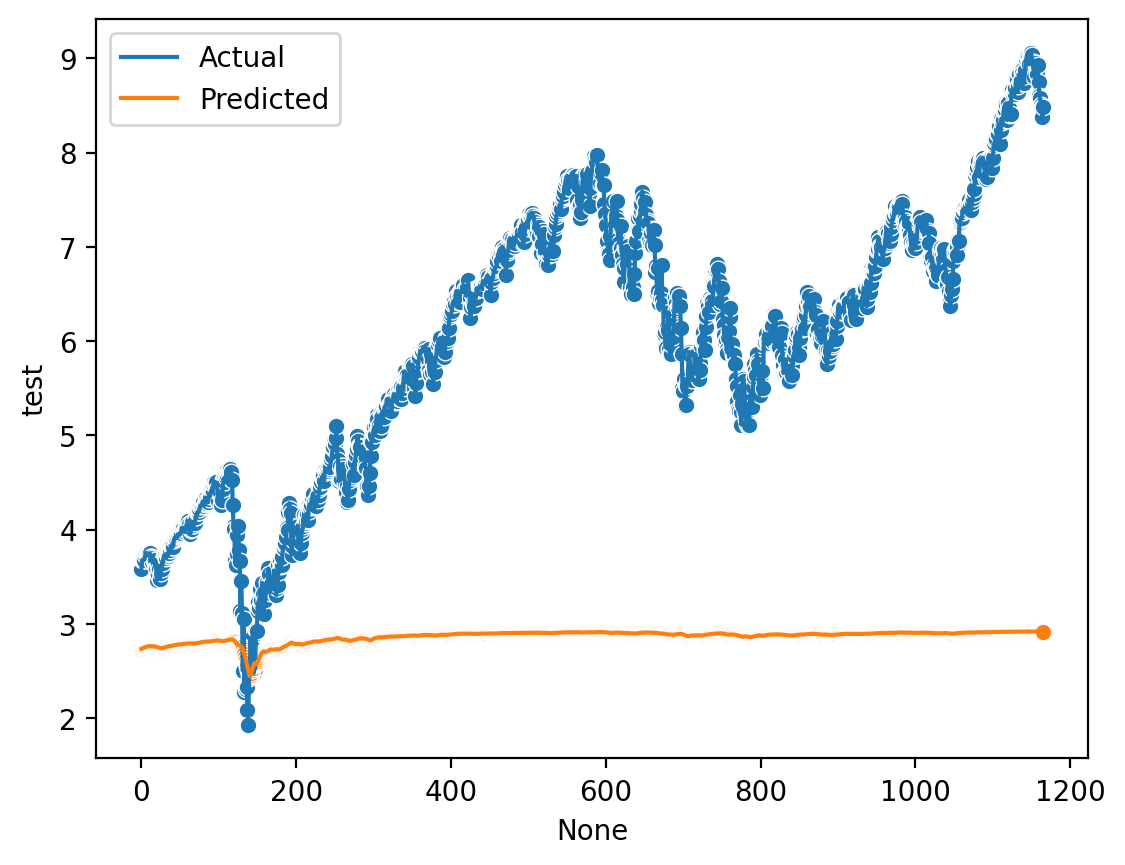

In [155]:
_, ax = plt.subplots(1, 1)
sns.lineplot(data=temp, y="test", x=temp.index, ax=ax, label="Actual")
sns.scatterplot(data=temp, y="test", x=temp.index, ax=ax)
sns.lineplot(data=temp, y="y_pred", x=temp.index, ax=ax, label="Predicted")
sns.scatterplot(data=temp, y="y_pred", x=temp.index, ax=ax)
plt.show()

In [63]:
eval_model = UnivariateLSTM.load_from_checkpoint(
    model_checkpoint.best_model_path,
    input_dim=1,
    hidden_dim=128,
    num_layers=3,
    output_dim=1,
)

In [67]:
forecast = model_forecast(
    eval_model,
    torch.tensor(sp500["Close"].values).float().to(device="mps"),
    N_LAGS,
    HORIZON,
)

torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size([1, 7, 1])
torch.Size